<a href="https://colab.research.google.com/github/pradyumna4998/Intro-to-ML/blob/main/HW7_Q2_Intro_to_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: V.pradyumna

student Id: 801345963

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 96.4 μs (started: 2024-12-05 22:17:54 -05:00)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

time: 1.8 s (started: 2024-12-05 22:17:54 -05:00)


In [ ]:
 # Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

time: 2.8 ms (started: 2024-12-05 22:17:55 -05:00)


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

time: 438 μs (started: 2024-12-05 22:17:55 -05:00)


In [ ]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and standard(std)
images = torch.stack([img_t for img_t, _ in training_dataset], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

Files already downloaded and verified
time: 2.63 s (started: 2024-12-05 22:17:55 -05:00)


In [ ]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 5.15 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 3.61 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 373 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 328 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
training_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
testing_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

time: 383 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 176 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
print(torch.__version__)

2.5.1
time: 130 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:

import datetime
def training_loop(epochs, optimizer, model, loss_function, training_loader):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        for images, labels in training_loader:
            images = images.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                training_loss / len(training_loader)))



time: 1.06 ms (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
class Residual_Block(nn.Module):
    def __init__(self, n_chans):
        super(Residual_Block, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

time: 1.7 ms (started: 2024-12-05 22:17:59 -05:00)


In [ ]:

import torch.nn.functional as F
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [Residual_Block(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

time: 593 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
device

device(type='cpu')

time: 2.14 ms (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_function = loss_fn,
    training_loader = training_loader,
)

2024-12-05 22:19:35.447654 Epoch 1, Training loss 1.580204714015746
2024-12-05 22:21:19.120756 Epoch 2, Training loss 1.2759407428084317
2024-12-05 22:24:42.954484 Epoch 4, Training loss 1.069437035595997
2024-12-05 22:28:14.340506 Epoch 6, Training loss 0.9455082878155809
2024-12-05 22:31:47.269249 Epoch 8, Training loss 0.8655828677227462
2024-12-05 22:35:29.860798 Epoch 10, Training loss 0.8056326306598429
2024-12-05 22:39:26.714407 Epoch 12, Training loss 0.7557469299033294
2024-12-05 22:43:17.690768 Epoch 14, Training loss 0.7110495313916234
2024-12-05 22:47:32.716469 Epoch 16, Training loss 0.6728168770489751
2024-12-05 22:51:29.313126 Epoch 18, Training loss 0.6376248637091557
2024-12-05 22:55:33.683729 Epoch 20, Training loss 0.6002947187488535
2024-12-05 22:59:38.117036 Epoch 22, Training loss 0.5720548164707228
2024-12-05 23:03:37.925190 Epoch 24, Training loss 0.540243014759996
2024-12-05 23:07:40.123597 Epoch 26, Training loss 0.5118897078905591
2024-12-05 23:11:43.410048 E

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
def validate(model, train_loader, val_loader):
    acc_dict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        acc_dict[name] = correct / total
    return acc_dict, predictions, exp_labels

time: 6.05 ms (started: 2024-12-06 04:43:20 -05:00)


In [ ]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.66
time: 33.2 s (started: 2024-12-06 04:43:20 -05:00)


In [ ]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.93      0.94      0.94      5911
  automobile       0.96      0.96      0.96      6023
        bird       0.92      0.91      0.92      6053
         cat       0.91      0.87      0.89      6246
        deer       0.92      0.94      0.93      5924
         dog       0.89      0.94      0.92      5710
        frog       0.94      0.96      0.95      5925
       horse       0.95      0.95      0.95      6004
        ship       0.97      0.92      0.95      6320
       truck       0.95      0.96      0.95      5884

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000

time: 118 ms (started: 2024-12-06 04:43:54 -05:00)


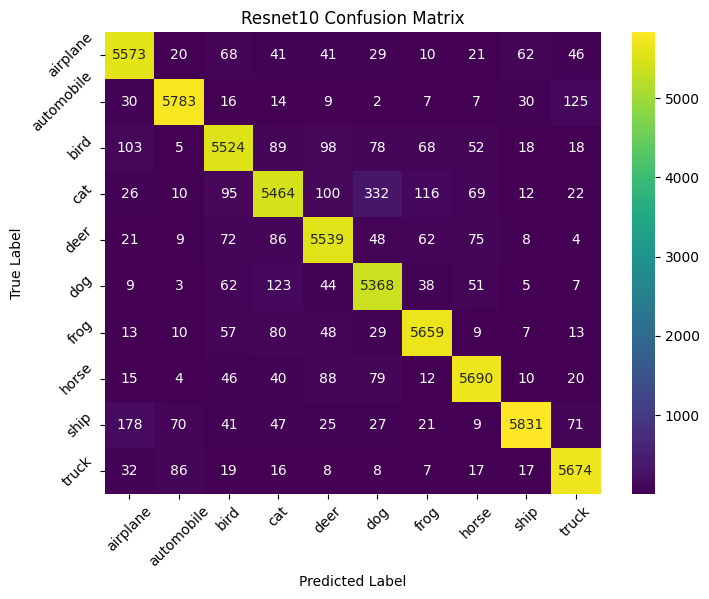

time: 321 ms (started: 2024-12-06 04:43:54 -05:00)


In [ ]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [ ]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


time: 3.56 ms (started: 2024-12-06 04:43:54 -05:00)


In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


time: 846 μs (started: 2024-12-06 04:43:54 -05:00)


In [ ]:
model_wd = NetWidth(n_chans1=32).to(device=device)
optimizer_wd = optim.SGD(model_wd.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


training_loop_l2reg(
    n_epochs = 200,
    optimizer = optimizer_wd,
    model = model_wd,
    loss_fn = loss_fn,
    train_loader = training_loader,
)

2024-12-06 04:44:24.680543 Epoch 1, Training loss 1.850588109732742
2024-12-06 04:44:53.818265 Epoch 2, Training loss 1.5306082206205611
2024-12-06 04:45:51.767413 Epoch 4, Training loss 1.2697488988963594
2024-12-06 04:46:49.527821 Epoch 6, Training loss 1.1416296338089291
2024-12-06 04:47:47.323479 Epoch 8, Training loss 1.0648797834369514
2024-12-06 04:48:45.174087 Epoch 10, Training loss 1.011142129861462
2024-12-06 04:49:42.757793 Epoch 12, Training loss 0.9751916298176795
2024-12-06 04:50:40.432598 Epoch 14, Training loss 0.9511718124399106
2024-12-06 04:51:38.197563 Epoch 16, Training loss 0.9301703854279875
2024-12-06 04:52:36.355835 Epoch 18, Training loss 0.9134020236197451
2024-12-06 04:53:34.072710 Epoch 20, Training loss 0.8989375203142392
2024-12-06 04:54:31.886427 Epoch 22, Training loss 0.8883117239824565
2024-12-06 04:55:29.584133 Epoch 24, Training loss 0.8767282355693541
2024-12-06 04:56:27.475972 Epoch 26, Training loss 0.8693487889211451
2024-12-06 04:57:25.159379 

In [ ]:

accuracy_weight_delay, predictions_weight_delay, expected_labels_weight_delay = validate(model_wd, train_loader, val_loader)


Accuracy train: 0.87
Accuracy val: 0.70
time: 10.3 s (started: 2024-12-06 06:19:49 -05:00)


In [ ]:
print(classification_report(predictions_weight_delay, expected_labels_weight_delay, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.86      0.85      0.85      6080
  automobile       0.89      0.94      0.92      5652
        bird       0.78      0.76      0.77      6133
         cat       0.66      0.80      0.72      5008
        deer       0.79      0.82      0.80      5743
         dog       0.80      0.78      0.79      6111
        frog       0.91      0.81      0.86      6797
       horse       0.88      0.87      0.87      6105
        ship       0.90      0.89      0.90      6096
       truck       0.92      0.88      0.90      6275

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000

time: 99.1 ms (started: 2024-12-06 06:20:00 -05:00)


In [ ]:
precision_weight_delay = precision_score(predictions_weight_delay, expected_labels_weight_delay, average='macro')
recall_weight_delay = recall_score(predictions_weight_delay, expected_labels_weight_delay, average='macro')
cnf_matrix_weight_delay = confusion_matrix(predictions_weight_delay, expected_labels_weight_delay)


time: 112 ms (started: 2024-12-06 06:20:00 -05:00)


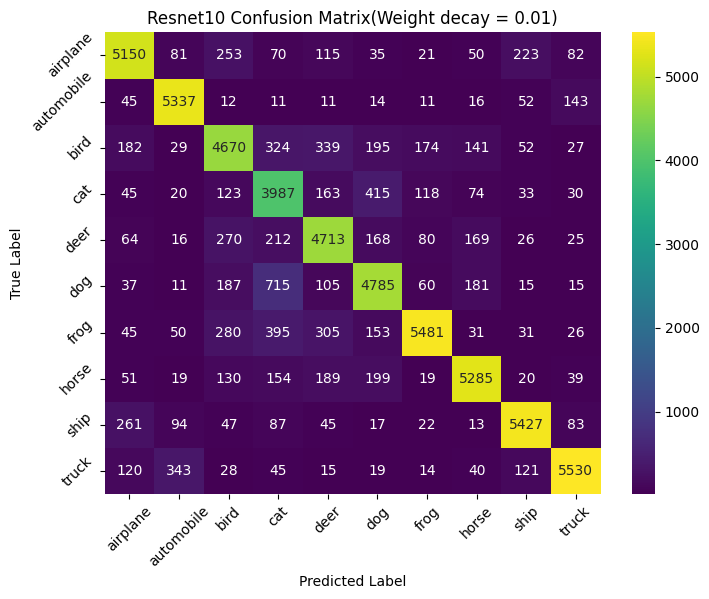

time: 227 ms (started: 2024-12-06 06:20:00 -05:00)


In [ ]:

plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_weight_delay, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix(Weight decay = 0.01)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 974 μs (started: 2024-12-06 06:20:00 -05:00)


In [ ]:
model_dropout = NetDropout(n_chans1=32).to(device=device)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 200,
    optimizer = optimizer_dropout,
    model = model_dropout,
    loss_function = loss_function,
    training_loader = training_loader,
)


2024-12-06 06:20:29.664753 Epoch 1, Training loss 1.9246388346586025
2024-12-06 06:20:58.416862 Epoch 2, Training loss 1.6218683708957273
2024-12-06 06:21:55.695319 Epoch 4, Training loss 1.4172304800055535
2024-12-06 06:22:52.997166 Epoch 6, Training loss 1.3204907902295362
2024-12-06 06:23:50.307423 Epoch 8, Training loss 1.2568986921148733
2024-12-06 06:24:47.577703 Epoch 10, Training loss 1.2081714347243233
2024-12-06 06:25:44.841593 Epoch 12, Training loss 1.1656097828464789
2024-12-06 06:26:41.974744 Epoch 14, Training loss 1.138589320774652
2024-12-06 06:27:39.431109 Epoch 16, Training loss 1.1185818738229596
2024-12-06 06:28:36.808891 Epoch 18, Training loss 1.0952422844623801
2024-12-06 06:29:33.992116 Epoch 20, Training loss 1.073983310356555
2024-12-06 06:30:31.176330 Epoch 22, Training loss 1.0705887182584117
2024-12-06 06:31:28.299733 Epoch 24, Training loss 1.058018323365344
2024-12-06 06:32:25.431255 Epoch 26, Training loss 1.0451347992844255
2024-12-06 06:33:22.576616 E

In [ ]:
accuracy_dropout, predictions_dropout, expected_labels_dropout = validate(model_dropout, train_loader, val_loader)

Accuracy train: 0.68
Accuracy val: 0.61
time: 10.5 s (started: 2024-12-06 07:55:31 -05:00)


In [ ]:
print(classification_report(predictions_dropout, expected_labels_dropout, target_names=class_names))


              precision    recall  f1-score   support

    airplane       0.69      0.73      0.71      5712
  automobile       0.78      0.81      0.79      5776
        bird       0.55      0.59      0.57      5586
         cat       0.46      0.51      0.49      5406
        deer       0.65      0.59      0.62      6650
         dog       0.56      0.58      0.57      5805
        frog       0.68      0.74      0.71      5467
       horse       0.74      0.67      0.71      6647
        ship       0.80      0.74      0.77      6489
       truck       0.79      0.73      0.76      6462

    accuracy                           0.67     60000
   macro avg       0.67      0.67      0.67     60000
weighted avg       0.68      0.67      0.67     60000

time: 98.5 ms (started: 2024-12-06 07:55:41 -05:00)


In [ ]:
precision_dropout = precision_score(predictions_dropout, expected_labels_dropout, average='macro')
recall_dropout = recall_score(predictions_dropout, expected_labels_dropout, average='macro')
cnf_matrix_dropout = confusion_matrix(predictions_dropout, expected_labels_dropout)

time: 108 ms (started: 2024-12-06 07:55:41 -05:00)


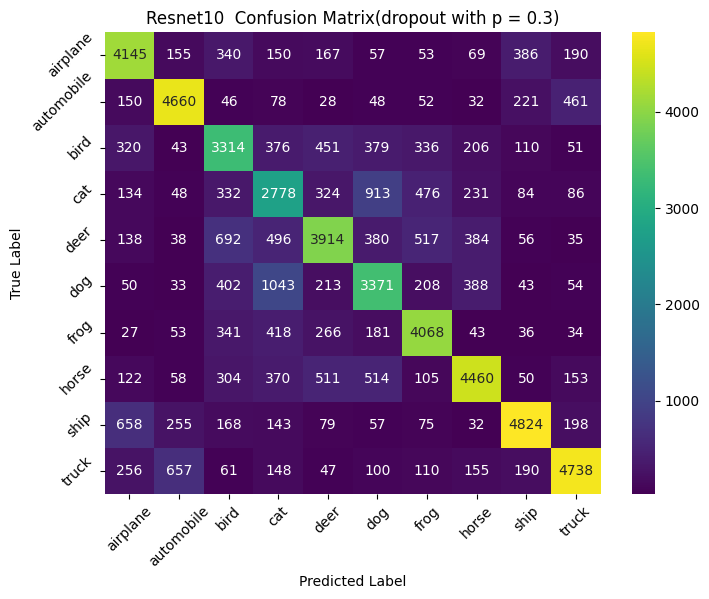

time: 502 ms (started: 2024-12-06 07:55:41 -05:00)


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_dropout, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10  Confusion Matrix(dropout with p = 0.3)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 1.01 ms (started: 2024-12-06 07:55:42 -05:00)


In [ ]:
model_batch_normalization = NetBatchNorm(n_chans1=32).to(device=device)
optimizer_batch_normalization = optim.SGD(model_batch_normalization.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 200,
    optimizer = optimizer_batch_normalization,
    model = model_batch_normalization,
    loss_function = loss_function,
    training_loader = training_loader,
)

2024-12-06 07:56:13.676881 Epoch 1, Training loss 1.63058377944424
2024-12-06 07:56:44.401343 Epoch 2, Training loss 1.3111197163260906
2024-12-06 07:57:45.707568 Epoch 4, Training loss 1.094605140821795
2024-12-06 07:58:46.617347 Epoch 6, Training loss 0.9821817722750716
2024-12-06 07:59:47.572048 Epoch 8, Training loss 0.9077674320357317
2024-12-06 08:00:48.749796 Epoch 10, Training loss 0.8505568959853318
2024-12-06 08:01:49.769755 Epoch 12, Training loss 0.8070790804660404
2024-12-06 08:02:50.851645 Epoch 14, Training loss 0.7700377028680961
2024-12-06 08:03:52.079327 Epoch 16, Training loss 0.7403066796289371
2024-12-06 08:04:53.829217 Epoch 18, Training loss 0.7151092436457779
2024-12-06 08:05:55.096829 Epoch 20, Training loss 0.6906690898226837
2024-12-06 08:06:56.262600 Epoch 22, Training loss 0.6683036088943481
2024-12-06 08:07:57.389807 Epoch 24, Training loss 0.6470994617758999
2024-12-06 08:08:58.366571 Epoch 26, Training loss 0.6259683669185455
2024-12-06 08:09:59.885003 E

In [ ]:
accuracy_batch_normalization, predictions_batch_normalization, expected_labels_batch_normalization = validate(model_dropout, train_loader, val_loader)

Accuracy train: 0.69
Accuracy val: 0.61
time: 10.6 s (started: 2024-12-06 09:37:22 -05:00)


In [ ]:
print(classification_report(predictions_dropout, expected_labels_dropout, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.69      0.73      0.71      5712
  automobile       0.78      0.81      0.79      5776
        bird       0.55      0.59      0.57      5586
         cat       0.46      0.51      0.49      5406
        deer       0.65      0.59      0.62      6650
         dog       0.56      0.58      0.57      5805
        frog       0.68      0.74      0.71      5467
       horse       0.74      0.67      0.71      6647
        ship       0.80      0.74      0.77      6489
       truck       0.79      0.73      0.76      6462

    accuracy                           0.67     60000
   macro avg       0.67      0.67      0.67     60000
weighted avg       0.68      0.67      0.67     60000

time: 101 ms (started: 2024-12-06 09:37:32 -05:00)


In [ ]:
precision_batch_norm = precision_score(predictions_batch_normalization, expected_labels_batch_normalization, average='macro')
recall_batch_norm = recall_score(predictions_batch_normalization, expected_labels_batch_normalization, average='macro')
cnf_matrix_batch_norm = confusion_matrix(predictions_batch_normalization, expected_labels_batch_normalization)

time: 116 ms (started: 2024-12-06 09:37:32 -05:00)


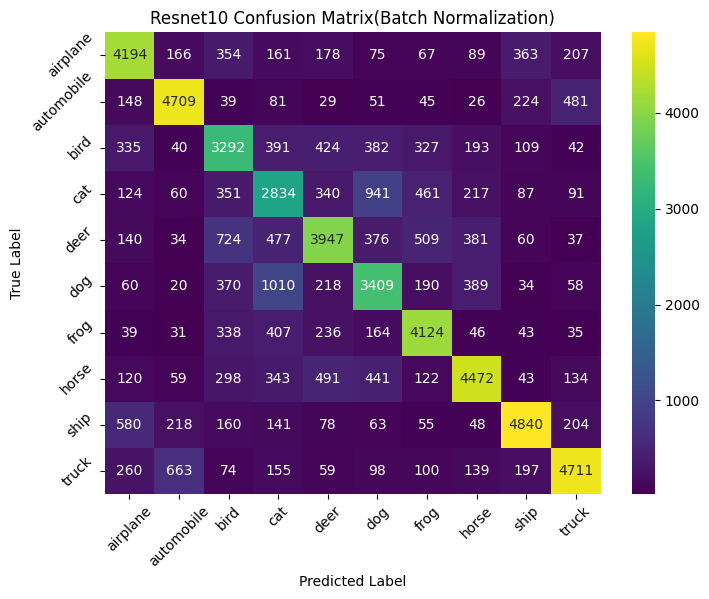

time: 284 ms (started: 2024-12-06 09:37:33 -05:00)


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_batch_norm, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix(Batch Normalization)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()
